# Predicting BitCoin prices
1. Get historic stock prices
2. Extract prices to predict
3. Normalise
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

# X and Y
X = Goes back looking over a series of time e.g. past 7 minutes<br>
Y = The last nth of the series of time e.g. the price of BTC on the 7th minute of the past 7 minutes.

In [1]:
# install dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# 1. Get historic stock prices
def allData():
    path = '../datasets/BTC/'
    
    ori_df = pd.read_csv(f"{path}gemini_BTCUSD_2015_1min.csv")
    for item in range(2016, 2022):
        df = pd.read_csv(f"{path}/gemini_BTCUSD_{item}_1min.csv")
        new_df = pd.concat([ori_df, df], ignore_index=True)
        ori_df = new_df

    ori_df.rename({"Unix Timestamp": "Timestamp"}, axis=1, inplace=True)
    combine_df = ori_df
    combine_df.drop_duplicates(subset=["Timestamp"], keep='first', inplace=True)
    
    return combine_df

data = allData()

# Data review

In [3]:
data.head()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1451606340,2015-12-31 23:59:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
1,1451606280,2015-12-31 23:58:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
2,1451606220,2015-12-31 23:57:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
3,1451606160,2015-12-31 23:56:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
4,1451606100,2015-12-31 23:55:00,BTCUSD,429.95,429.95,429.95,429.95,0.0


In [4]:
data.tail()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume
3050922,1609459440000,2021-01-01 00:04:00,BTCUSD,29056.21,29056.21,29046.04,29048.46,0.032502
3050923,1609459380000,2021-01-01 00:03:00,BTCUSD,29057.27,29057.27,29028.69,29056.21,0.049909
3050924,1609459320000,2021-01-01 00:02:00,BTCUSD,29085.38,29086.14,29043.25,29057.27,5.075271
3050925,1609459260000,2021-01-01 00:01:00,BTCUSD,29033.01,29086.14,29033.01,29085.38,1.451389
3050926,1609459200000,2021-01-01 00:00:00,BTCUSD,28979.74,29033.01,28956.18,29033.01,0.126441


In [5]:
data.columns

Index(['Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')

In [6]:
data = data.drop(columns=['Date', 'Symbol', 'Open', 'High', 'Low', 'Volume'])

In [7]:
data.shape

(3050927, 2)

In [8]:
data.describe()

,Timestamp,Close
count,3.050927e+06,3.050927e+06
mean,8.009380e+11,1.089529e+04
std,7.923166e+11,1.427358e+04
min,1.444312e+09,2.360000e+02
25%,1.490075e+09,1.178570e+03
50%,1.536069e+12,6.765350e+03
75%,1.586757e+12,1.042789e+04
max,1.633651e+12,6.489000e+04


In [9]:
data.dtypes

Timestamp      int64
Close        float64
dtype: object

In [10]:
data.set_index('Timestamp', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050927 entries, 1451606340 to 1609459200000
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Close   float64
dtypes: float64(1)
memory usage: 46.6 MB


In [11]:
data.sort_index(inplace=True)

In [12]:
data_close = data['Close']
data_close

Timestamp
1444311600         242.50
1444311660         242.95
1444311720         242.95
1444311780         242.96
1444311840         242.96
                   ...   
1633651200000    53841.33
1633651260000    53857.19
1633651320000    53779.86
1633651380000    53744.05
1633651440000    53823.93
Name: Close, Length: 3050927, dtype: float64

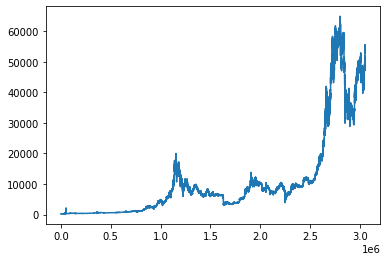

In [13]:
data_close = data_close.values.reshape(len(data_close), 1)
plt.plot(data_close)
plt.show()

# Preprocessing: scaling and normalising the data

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))

In [15]:
data_close = scaler.fit_transform(data_close)
data_close

array([[1.00535156e-04],
       [1.07495283e-04],
       [1.07495283e-04],
       ...,
       [8.28160052e-01],
       [8.27606181e-01],
       [8.28841680e-01]])

In [16]:
# split data into train and test
train_size = int(len(data_close) * 0.8)

data_train = data_close[:train_size, :]
data_test = data_close[train_size:, :]

print('Train data size: ', len(data_train))
print('Test data size: ', len(data_test))

Train data size:  2440741
Test data size:  610186


In [17]:
# need to now convert the data into time series looking back over a period of days...e.g. use last 60 minutes to predict price
def create_ts(ds, look_back):
    X = []
    Y = []
    for i in range(len(ds) - look_back - 1):
        item = ds[i:(i + look_back), 0]
        X.append(item)
        Y.append(ds[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10

trainX, trainY = create_ts(data_train, look_back)
testX, testY = create_ts(data_test, look_back)

In [18]:
# reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [19]:
# build the model
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit the model
model.fit(trainX, trainY, epochs=1, batch_size=32)

76273/76273 [==============================] - 428s 6ms/step - loss: 5.5399e-06


In [20]:
# test the model out
prediction = model.predict(testX)

# unscale predictions
prediction = scaler.inverse_transform(prediction)
testY = scaler.inverse_transform([testY])

In [21]:
# Calculate the root mean squared error
predictionScore = math.sqrt(mean_squared_error(testY[0], prediction[:, 0]))
print('Prediction score: %.2f rmse', predictionScore)

Prediction score: %.2f rmse 1856.8822879994088


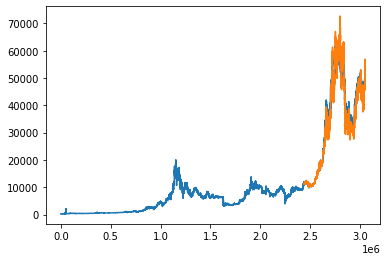

In [27]:
# Plot the predictions on a graph
prediction_plot = np.empty_like(data_close)
prediction_plot[:,:] = np.nan
prediction_plot[len(data_train) + look_back:len(data_close) - 1, :] = prediction

plt.plot(scaler.inverse_transform(data_close))
plt.plot(prediction_plot)
plt.show()

In [41]:
prediction_list = data_close[-11:, :]
x, y = create_ts(prediction_list, 10)

In [42]:
x

array([], dtype=float64)

In [35]:
#data_close = data_close.reshape((-1))

def predict(num_prediction, model):
    prediction_list = data_close[-look_back:]
    
    for i in range(num_prediction):
        x, y = create_ts(prediction_list, look_back)
        x = np.reshape(x, (x.shape[0], 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

num_prediction = 100
forecast = predict(num_prediction, model)

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [31]:
forecast

array([8.28841680e-01, 8.36364686e-01, 8.38328362e-01, 8.40555489e-01,
       8.43068182e-01, 8.45920682e-01, 8.49151194e-01, 8.52822304e-01,
       8.56944561e-01, 8.61665964e-01, 8.66966426e-01, 8.72844160e-01,
       8.79137218e-01, 8.86187017e-01, 8.94099176e-01, 9.02998567e-01,
       9.13032889e-01, 9.24380660e-01, 9.37256932e-01, 9.51930881e-01,
       9.68731582e-01, 9.88081396e-01, 1.01052225e+00, 1.03676677e+00,
       1.06773901e+00, 1.10468030e+00, 1.14930046e+00, 1.20401466e+00,
       1.27234447e+00, 1.35962093e+00, 1.47428453e+00, 1.63046849e+00,
       1.85356748e+00, 2.17657113e+00, 2.66470122e+00, 3.47444987e+00,
       5.03979015e+00, 7.55634689e+00, 1.08125992e+01, 1.56048479e+01,
       2.26121731e+01, 3.29015999e+01, 4.76180763e+01, 6.89760132e+01,
       9.99731903e+01, 1.44853958e+02, 2.09514984e+02, 3.03118011e+02,
       4.37591919e+02, 6.32191833e+02, 9.14135681e+02, 1.32138635e+03,
       1.90988379e+03, 2.76046265e+03, 3.98980688e+03, 5.76647510e+03,
      

In [ ]:
data_close

In [ ]:
plt.plot(data_close)
plt.show()

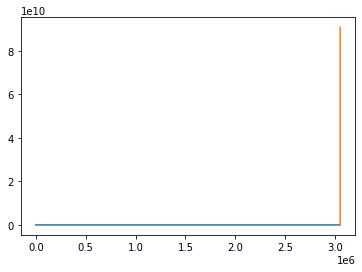

In [33]:
forecast_plot = np.empty_like(np.append(data_close, forecast))
forecast_plot[:] = np.nan
forecast_plot[len(data_close):] = forecast

plt.plot(data_close)
plt.plot(forecast_plot)
plt.show()

In [ ]:
plt.plot(forecast)
plt.show()